<a href="https://colab.research.google.com/github/tanoManzo/mimic_trajectories/blob/dev/MIMIC_TRAJECTORY_embeddings_04_collect_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Collection, Embeddings and Attitude

analyzing words in future dataset

In [1]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


imports for counting words

In [3]:
import re
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('sentiwordnet')
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.


In [4]:
! pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 73.8 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForSequenceClassification
import seaborn as sns

load nursing notes subject-caregiver-chartdate

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!ls "/content/drive"

MyDrive


In [6]:
notes_path = "/content/drive/MyDrive/NIH/Data/"
notes_name = "NOTES_NURSING_TRAJECTORIES_01.csv"
df_notes = pd.read_csv(notes_path+notes_name)
df_notes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531675 entries, 0 to 531674
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ROW_ID      531675 non-null  int64 
 1   SUBJECT_ID  531675 non-null  int64 
 2   CGID        531675 non-null  int64 
 3   CHARTDATE   531675 non-null  object
 4   TEXT        531675 non-null  object
dtypes: int64(3), object(2)
memory usage: 20.3+ MB


In [7]:
note_events = "NOTEEVENTS.csv"
df_note_events = pd.read_csv(notes_path+note_events)
df_note_events.info()

<ipython-input-7-8fd00f55f791>:2: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_note_events = pd.read_csv(notes_path+note_events)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2083180 entries, 0 to 2083179
Data columns (total 11 columns):
 #   Column       Dtype  
---  ------       -----  
 0   ROW_ID       int64  
 1   SUBJECT_ID   int64  
 2   HADM_ID      float64
 3   CHARTDATE    object 
 4   CHARTTIME    object 
 5   STORETIME    object 
 6   CATEGORY     object 
 7   DESCRIPTION  object 
 8   CGID         float64
 9   ISERROR      float64
 10  TEXT         object 
dtypes: float64(3), int64(2), object(6)
memory usage: 174.8+ MB


In [8]:
print(df_note_events['CATEGORY'].unique())

['Discharge summary' 'Echo' 'ECG' 'Nursing' 'Physician ' 'Rehab Services'
 'Case Management ' 'Respiratory ' 'Nutrition' 'General' 'Social Work'
 'Pharmacy' 'Consult' 'Radiology' 'Nursing/other']


In [9]:
patients = "PATIENTS.csv"
df_patients = pd.read_csv(notes_path+patients)
df_patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46520 entries, 0 to 46519
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ROW_ID       46520 non-null  int64 
 1   SUBJECT_ID   46520 non-null  int64 
 2   GENDER       46520 non-null  object
 3   DOB          46520 non-null  object
 4   DOD          15759 non-null  object
 5   DOD_HOSP     9974 non-null   object
 6   DOD_SSN      13378 non-null  object
 7   EXPIRE_FLAG  46520 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 2.8+ MB


In [10]:
caregivers = "CAREGIVERS.csv"
df_caregivers = pd.read_csv(notes_path+caregivers)
df_caregivers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7567 entries, 0 to 7566
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ROW_ID       7567 non-null   int64 
 1   CGID         7567 non-null   int64 
 2   LABEL        7518 non-null   object
 3   DESCRIPTION  5155 non-null   object
dtypes: int64(2), object(2)
memory usage: 236.6+ KB


In [22]:
ward_name = "ICUSTAYS.csv"
df_ward = pd.read_csv(notes_path+ward_name)
df_ward.info()
df_ward['first_careunit'].unique()
df_ward['ROW_ID'] = df_ward['row_id']
df_ward['SUBJECT_ID'] = df_ward['subject_id']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   row_id          136 non-null    int64  
 1   subject_id      136 non-null    int64  
 2   hadm_id         136 non-null    int64  
 3   icustay_id      136 non-null    int64  
 4   dbsource        136 non-null    object 
 5   first_careunit  136 non-null    object 
 6   last_careunit   136 non-null    object 
 7   first_wardid    136 non-null    int64  
 8   last_wardid     136 non-null    int64  
 9   intime          136 non-null    object 
 10  outtime         136 non-null    object 
 11  los             136 non-null    float64
dtypes: float64(1), int64(6), object(5)
memory usage: 12.9+ KB


In [11]:
icd = "DIAGNOSES_ICD.csv"
df_icd = pd.read_csv(notes_path+icd)
df_icd.columns = df_icd.columns.str.upper()
df_icd = df_icd.dropna(subset=['SEQ_NUM'])
df_icd['SEQ_NUM'] = df_icd['SEQ_NUM'].astype(int)
unique_values = df_icd['SEQ_NUM'].unique()
print("unique_values: ")
print(unique_values)
idx = df_icd.groupby(['HADM_ID', 'SUBJECT_ID'])['SEQ_NUM'].idxmin()
df_icd = df_icd.loc[idx]
df_icd.info()


unique_values: 
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 129 entries, 230 to 71
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ROW_ID      129 non-null    int64 
 1   SUBJECT_ID  129 non-null    int64 
 2   HADM_ID     129 non-null    int64 
 3   SEQ_NUM     129 non-null    int64 
 4   ICD9_CODE   129 non-null    object
dtypes: int64(4), object(1)
memory usage: 6.0+ KB


## **Data Preprocessing**

Grab tsicu notes, merge with ward and patients tables

In [24]:
# get new type of notes (TSICU)
df_notes_TSICU = pd.DataFrame()
df_notes_TSICU = df_notes.merge(df_note_events[['ROW_ID', 'CATEGORY']], on='ROW_ID')
df_notes_TSICU = df_notes_TSICU.merge(df_caregivers.drop('ROW_ID', axis=1), on='CGID')
df_notes_TSICU = df_notes_TSICU.merge(df_ward.drop('ROW_ID', axis=1), on='SUBJECT_ID')
df_notes_TSICU = df_notes_TSICU.merge(df_patients.drop('ROW_ID', axis=1), on='SUBJECT_ID')
df_notes_TSICU = df_notes_TSICU[(df_notes_TSICU['first_careunit'] == 'TSICU') & (df_notes_TSICU['last_careunit'] == 'TSICU')].drop_duplicates()
df_notes_TSICU.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65 entries, 775 to 908
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID          65 non-null     int64  
 1   SUBJECT_ID      65 non-null     int64  
 2   CGID            65 non-null     int64  
 3   CHARTDATE       65 non-null     object 
 4   TEXT            65 non-null     object 
 5   CATEGORY        65 non-null     object 
 6   LABEL           64 non-null     object 
 7   DESCRIPTION     29 non-null     object 
 8   row_id          65 non-null     int64  
 9   subject_id      65 non-null     int64  
 10  hadm_id         65 non-null     int64  
 11  icustay_id      65 non-null     int64  
 12  dbsource        65 non-null     object 
 13  first_careunit  65 non-null     object 
 14  last_careunit   65 non-null     object 
 15  first_wardid    65 non-null     int64  
 16  last_wardid     65 non-null     int64  
 17  intime          65 non-null     ob

In [25]:
df_notes_TSICU.head(5)

,ROW_ID,SUBJECT_ID,CGID,CHARTDATE,TEXT,CATEGORY,LABEL,DESCRIPTION,row_id,subject_id,...,last_wardid,intime,outtime,los,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
775,1395715,10127,19087,2198-07-03,"TSICU Nursing Progress Note\nNeuro - Alert, fo...",Nursing/other,RN,NaN,12870,10127,...,14,2198-06-28 05:35:32,2198-07-20 14:56:23,22.3895,F,2181-04-19 00:00:00,2201-11-08 00:00:00,NaN,2201-11-08 00:00:00,1
776,1395759,10127,19087,2198-07-13,TSICU Nursing Progress Note\nNeuro - Remains w...,Nursing/other,RN,NaN,12870,10127,...,14,2198-06-28 05:35:32,2198-07-20 14:56:23,22.3895,F,2181-04-19 00:00:00,2201-11-08 00:00:00,NaN,2201-11-08 00:00:00,1
777,1395751,10127,19087,2198-07-11,TSICU Nursing Progress Note\nNeuro - Awake and...,Nursing/other,RN,NaN,12870,10127,...,14,2198-06-28 05:35:32,2198-07-20 14:56:23,22.3895,F,2181-04-19 00:00:00,2201-11-08 00:00:00,NaN,2201-11-08 00:00:00,1
778,1395746,10127,19087,2198-07-10,"TSICU Nursing Progress Note\nNeuro - Alert, no...",Nursing/other,RN,NaN,12870,10127,...,14,2198-06-28 05:35:32,2198-07-20 14:56:23,22.3895,F,2181-04-19 00:00:00,2201-11-08 00:00:00,NaN,2201-11-08 00:00:00,1
779,1395698,10127,18792,2198-06-29,TSICU NPN 7p-7a\nS/O-\n\n[**Name (NI) 248**] p...,Nursing/other,RN,RN,12870,10127,...,14,2198-06-28 05:35:32,2198-07-20 14:56:23,22.3895,F,2181-04-19 00:00:00,2201-11-08 00:00:00,NaN,2201-11-08 00:00:00,1


Join with ICD

In [26]:
df_notes_TSICU = df_notes_TSICU.merge(df_icd[['HADM_ID','ICD9_CODE','SEQ_NUM', 'SUBJECT_ID']], on=['HADM_ID', 'SUBJECT_ID'])
df_notes_TSICU.info()

KeyError: ignored

In [27]:
df_notes_TSICU.head(20)

,ROW_ID,SUBJECT_ID,CGID,CHARTDATE,TEXT,CATEGORY,LABEL,DESCRIPTION,row_id,subject_id,...,last_wardid,intime,outtime,los,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
775,1395715,10127,19087,2198-07-03,"TSICU Nursing Progress Note\nNeuro - Alert, fo...",Nursing/other,RN,NaN,12870,10127,...,14,2198-06-28 05:35:32,2198-07-20 14:56:23,22.3895,F,2181-04-19 00:00:00,2201-11-08 00:00:00,NaN,2201-11-08 00:00:00,1
776,1395759,10127,19087,2198-07-13,TSICU Nursing Progress Note\nNeuro - Remains w...,Nursing/other,RN,NaN,12870,10127,...,14,2198-06-28 05:35:32,2198-07-20 14:56:23,22.3895,F,2181-04-19 00:00:00,2201-11-08 00:00:00,NaN,2201-11-08 00:00:00,1
777,1395751,10127,19087,2198-07-11,TSICU Nursing Progress Note\nNeuro - Awake and...,Nursing/other,RN,NaN,12870,10127,...,14,2198-06-28 05:35:32,2198-07-20 14:56:23,22.3895,F,2181-04-19 00:00:00,2201-11-08 00:00:00,NaN,2201-11-08 00:00:00,1
778,1395746,10127,19087,2198-07-10,"TSICU Nursing Progress Note\nNeuro - Alert, no...",Nursing/other,RN,NaN,12870,10127,...,14,2198-06-28 05:35:32,2198-07-20 14:56:23,22.3895,F,2181-04-19 00:00:00,2201-11-08 00:00:00,NaN,2201-11-08 00:00:00,1
779,1395698,10127,18792,2198-06-29,TSICU NPN 7p-7a\nS/O-\n\n[**Name (NI) 248**] p...,Nursing/other,RN,RN,12870,10127,...,14,2198-06-28 05:35:32,2198-07-20 14:56:23,22.3895,F,2181-04-19 00:00:00,2201-11-08 00:00:00,NaN,2201-11-08 00:00:00,1
780,1395693,10127,18792,2198-06-28,TSICU Admitting Note\nPlease see FHPA and care...,Nursing/other,RN,RN,12870,10127,...,14,2198-06-28 05:35:32,2198-07-20 14:56:23,22.3895,F,2181-04-19 00:00:00,2201-11-08 00:00:00,NaN,2201-11-08 00:00:00,1
781,1395744,10127,16140,2198-07-10,[**Name (NI) 2000**] NPN\nPt remains in the T-...,Nursing/other,RN,NaN,12870,10127,...,14,2198-06-28 05:35:32,2198-07-20 14:56:23,22.3895,F,2181-04-19 00:00:00,2201-11-08 00:00:00,NaN,2201-11-08 00:00:00,1
782,1395724,10127,15709,2198-07-05,NPN 7pm-7am\n\nROS: (See Carevue for exact ch...,Nursing/other,RNs,RN,12870,10127,...,14,2198-06-28 05:35:32,2198-07-20 14:56:23,22.3895,F,2181-04-19 00:00:00,2201-11-08 00:00:00,NaN,2201-11-08 00:00:00,1
783,1395772,10127,15709,2198-07-17,NPN 7pm-7am\n\nEvents of Shift: MRI/MRA with ...,Nursing/other,RNs,RN,12870,10127,...,14,2198-06-28 05:35:32,2198-07-20 14:56:23,22.3895,F,2181-04-19 00:00:00,2201-11-08 00:00:00,NaN,2201-11-08 00:00:00,1
784,1395729,10127,15709,2198-07-06,NPN 7pm-7am\nROS: See carevue for exacts\n\nNe...,Nursing/other,RNs,RN,12870,10127,...,14,2198-06-28 05:35:32,2198-07-20 14:56:23,22.3895,F,2181-04-19 00:00:00,2201-11-08 00:00:00,NaN,2201-11-08 00:00:00,1


In [ ]:
grouping = df_notes_TSICU.groupby(['CGID','SUBJECT_ID']).size()
df_notes_TSICU['num_of_notes'] = df_notes_TSICU.set_index(['CGID','SUBJECT_ID']).index.map(grouping)
df_notes_TSICU_filtered = df_notes_TSICU[df_notes_TSICU['num_of_notes'] > 1]
df_notes_TSICU_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34283 entries, 0 to 48418
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID          34283 non-null  int64  
 1   SUBJECT_ID      34283 non-null  int64  
 2   CGID            34283 non-null  int64  
 3   CHARTDATE       34283 non-null  object 
 4   TEXT            34283 non-null  object 
 5   CATEGORY        34283 non-null  object 
 6   LABEL           31732 non-null  object 
 7   DESCRIPTION     19285 non-null  object 
 8   HADM_ID         34283 non-null  int64  
 9   ICUSTAY_ID      34283 non-null  int64  
 10  DBSOURCE        34283 non-null  object 
 11  FIRST_CAREUNIT  34283 non-null  object 
 12  LAST_CAREUNIT   34283 non-null  object 
 13  FIRST_WARDID    34283 non-null  int64  
 14  LAST_WARDID     34283 non-null  int64  
 15  INTIME          34283 non-null  object 
 16  OUTTIME         34283 non-null  object 
 17  LOS             34283 non-null 

In [ ]:
df_notes_TSICU_filtered.head(10)

,ROW_ID,SUBJECT_ID,CGID,CHARTDATE,TEXT,CATEGORY,LABEL,DESCRIPTION,HADM_ID,ICUSTAY_ID,...,LOS,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,ICD9_CODE,SEQ_NUM,num_of_notes
0,1554291,22312,18679,2127-12-07,NSG ADM NOTE-MICU\nMrs.[**Known lastname 662**...,Nursing/other,RN,RN,158950,217912,...,1.8809,F,2054-07-11 00:00:00,2128-11-05 00:00:00,NaN,2128-11-05 00:00:00,1,56089,1,2
1,1554293,22312,18679,2127-12-08,NPN-MICU\nMrs [**Known lastname 662**] has bee...,Nursing/other,RN,RN,158950,217912,...,1.8809,F,2054-07-11 00:00:00,2128-11-05 00:00:00,NaN,2128-11-05 00:00:00,1,56089,1,2
12,1596525,25658,18240,2178-10-30,CCU Nursing Admission Note 1130-1900\nSee CCU ...,Nursing/other,RN,RN,172975,290945,...,2.8200,M,2110-03-24 00:00:00,2179-02-10 00:00:00,2179-02-10 00:00:00,2179-02-10 00:00:00,1,99661,1,2
13,1596532,25658,18240,2178-11-02,CCU Nursing Progress Note 0700-1500\nS: winci...,Nursing/other,RN,RN,172975,290945,...,2.8200,M,2110-03-24 00:00:00,2179-02-10 00:00:00,2179-02-10 00:00:00,2179-02-10 00:00:00,1,99661,1,2
14,1596511,25658,21058,2178-03-03,"S: ""My legs look swollen all the time.""\n\nO:C...",Nursing/other,RN,RN,172975,290945,...,2.8200,M,2110-03-24 00:00:00,2179-02-10 00:00:00,2179-02-10 00:00:00,2179-02-10 00:00:00,1,99661,1,2
15,1596509,25658,21058,2178-03-02,ADDENDUM:CV: SECOND CPK NEGATIVE (115) NPO MID...,Nursing/other,RN,RN,172975,290945,...,2.8200,M,2110-03-24 00:00:00,2179-02-10 00:00:00,2179-02-10 00:00:00,2179-02-10 00:00:00,1,99661,1,2
16,1596569,25658,20866,2179-01-17,CCU Nursing MICU border progress Note 7am-7pm\...,Nursing/other,RN,RN,172975,290945,...,2.8200,M,2110-03-24 00:00:00,2179-02-10 00:00:00,2179-02-10 00:00:00,2179-02-10 00:00:00,1,99661,1,5
17,1596578,25658,20866,2179-01-19,CCU Nursing Progress Note 7am-7pm\nS: Orally ...,Nursing/other,RN,RN,172975,290945,...,2.8200,M,2110-03-24 00:00:00,2179-02-10 00:00:00,2179-02-10 00:00:00,2179-02-10 00:00:00,1,99661,1,5
18,1596561,25658,20866,2179-01-15,CCU Nursing Progress Note 1500-1900\nS: Orall...,Nursing/other,RN,RN,172975,290945,...,2.8200,M,2110-03-24 00:00:00,2179-02-10 00:00:00,2179-02-10 00:00:00,2179-02-10 00:00:00,1,99661,1,5
19,1596566,25658,20866,2179-01-16,CCU Nursing Progress Note 0700-1900\nS: Orall...,Nursing/other,RN,RN,172975,290945,...,2.8200,M,2110-03-24 00:00:00,2179-02-10 00:00:00,2179-02-10 00:00:00,2179-02-10 00:00:00,1,99661,1,5


Filter by number of notes

number of notes: min=2, max=1292, mean=50.86498516320475,  median=18.0


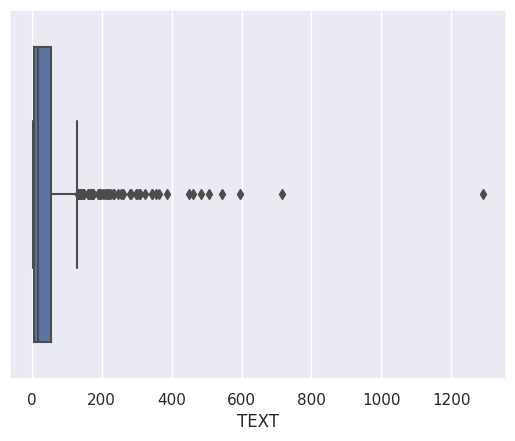

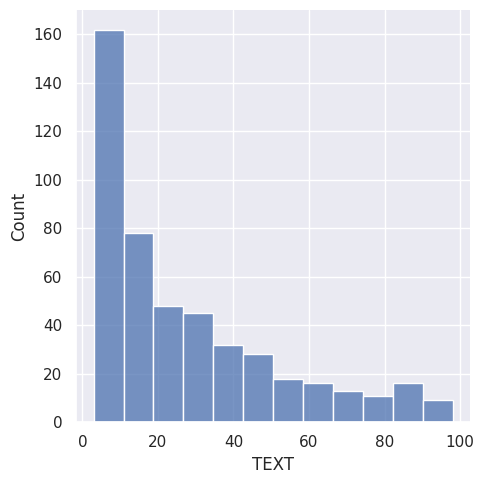

In [ ]:
gb_notes = df_notes_TSICU_filtered.groupby(['ICD9_CODE'])
num_notes = gb_notes['TEXT'].count()

print(f'number of notes: min={num_notes.min()}, max={num_notes.max()}, mean={num_notes.mean()},  median={num_notes.median()}')
sns.boxplot(x=num_notes)
sns.displot(num_notes[((num_notes>2) & (num_notes<100))])

In [ ]:
df_notes_TSICU_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34283 entries, 0 to 48418
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID          34283 non-null  int64  
 1   SUBJECT_ID      34283 non-null  int64  
 2   CGID            34283 non-null  int64  
 3   CHARTDATE       34283 non-null  object 
 4   TEXT            34283 non-null  object 
 5   CATEGORY        34283 non-null  object 
 6   LABEL           31732 non-null  object 
 7   DESCRIPTION     19285 non-null  object 
 8   HADM_ID         34283 non-null  int64  
 9   ICUSTAY_ID      34283 non-null  int64  
 10  DBSOURCE        34283 non-null  object 
 11  FIRST_CAREUNIT  34283 non-null  object 
 12  LAST_CAREUNIT   34283 non-null  object 
 13  FIRST_WARDID    34283 non-null  int64  
 14  LAST_WARDID     34283 non-null  int64  
 15  INTIME          34283 non-null  object 
 16  OUTTIME         34283 non-null  object 
 17  LOS             34283 non-null 

In [ ]:
icd9_grouping = df_notes_TSICU_filtered.groupby(['ICD9_CODE']).size()
df_notes_TSICU_filtered['num_of_conditions'] = df_notes_TSICU_filtered.set_index(['ICD9_CODE']).index.map(icd9_grouping)
#df_notes_TSICU_filtered = df_notes_TSICU_filtered[(df_notes_TSICU_filtered['num_of_conditions'] >= 15) & (df_notes_TSICU_filtered['num_of_conditions'] <= 1000)]
#df_notes_TSICU_filtered = df_notes_TSICU_filtered[(df_notes_TSICU_filtered['num_of_conditions'] >= 15) & (df_notes_TSICU_filtered['num_of_conditions'] <= 100)]
df_notes_TSICU_filtered.info()
print(icd9_grouping)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34283 entries, 0 to 48418
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ROW_ID             34283 non-null  int64  
 1   SUBJECT_ID         34283 non-null  int64  
 2   CGID               34283 non-null  int64  
 3   CHARTDATE          34283 non-null  object 
 4   TEXT               34283 non-null  object 
 5   CATEGORY           34283 non-null  object 
 6   LABEL              31732 non-null  object 
 7   DESCRIPTION        19285 non-null  object 
 8   HADM_ID            34283 non-null  int64  
 9   ICUSTAY_ID         34283 non-null  int64  
 10  DBSOURCE           34283 non-null  object 
 11  FIRST_CAREUNIT     34283 non-null  object 
 12  LAST_CAREUNIT      34283 non-null  object 
 13  FIRST_WARDID       34283 non-null  int64  
 14  LAST_WARDID        34283 non-null  int64  
 15  INTIME             34283 non-null  object 
 16  OUTTIME            342

<ipython-input-201-2f58a0fcdd04>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notes_TSICU_filtered['num_of_conditions'] = df_notes_TSICU_filtered.set_index(['ICD9_CODE']).index.map(icd9_grouping)


In [ ]:
df_notes_TSICU_dropped_cols = df_notes_TSICU_filtered.drop(['FIRST_CAREUNIT', 'LAST_CAREUNIT', 'FIRST_WARDID','LAST_WARDID','INTIME', 'OUTTIME', 'DBSOURCE','DOB','DOD','DOD_HOSP','DOD_SSN','CHARTDATE'], axis=1)
df_notes_TSICU_dropped_cols.head(10)

,ROW_ID,SUBJECT_ID,CGID,TEXT,CATEGORY,LABEL,DESCRIPTION,HADM_ID,ICUSTAY_ID,LOS,GENDER,EXPIRE_FLAG,ICD9_CODE,SEQ_NUM,num_of_notes,num_of_conditions
0,1554291,22312,18679,NSG ADM NOTE-MICU\nMrs.[**Known lastname 662**...,Nursing/other,RN,RN,158950,217912,1.8809,F,1,56089,1,2,4
1,1554293,22312,18679,NPN-MICU\nMrs [**Known lastname 662**] has bee...,Nursing/other,RN,RN,158950,217912,1.8809,F,1,56089,1,2,4
12,1596525,25658,18240,CCU Nursing Admission Note 1130-1900\nSee CCU ...,Nursing/other,RN,RN,172975,290945,2.8200,M,1,99661,1,2,41
13,1596532,25658,18240,CCU Nursing Progress Note 0700-1500\nS: winci...,Nursing/other,RN,RN,172975,290945,2.8200,M,1,99661,1,2,41
14,1596511,25658,21058,"S: ""My legs look swollen all the time.""\n\nO:C...",Nursing/other,RN,RN,172975,290945,2.8200,M,1,99661,1,2,41
15,1596509,25658,21058,ADDENDUM:CV: SECOND CPK NEGATIVE (115) NPO MID...,Nursing/other,RN,RN,172975,290945,2.8200,M,1,99661,1,2,41
16,1596569,25658,20866,CCU Nursing MICU border progress Note 7am-7pm\...,Nursing/other,RN,RN,172975,290945,2.8200,M,1,99661,1,5,41
17,1596578,25658,20866,CCU Nursing Progress Note 7am-7pm\nS: Orally ...,Nursing/other,RN,RN,172975,290945,2.8200,M,1,99661,1,5,41
18,1596561,25658,20866,CCU Nursing Progress Note 1500-1900\nS: Orall...,Nursing/other,RN,RN,172975,290945,2.8200,M,1,99661,1,5,41
19,1596566,25658,20866,CCU Nursing Progress Note 0700-1900\nS: Orall...,Nursing/other,RN,RN,172975,290945,2.8200,M,1,99661,1,5,41


Inverse Document Frequency

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_notes_TSICU['TEXT'])

feature_names = vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.sum(axis=0).A1
word_score_dict = dict(zip(feature_names, tfidf_scores))

sorted_words = sorted(word_score_dict.items(), key=lambda x: x[1], reverse=True)

top_words = sorted_words[:50]

In [ ]:
print("Rank\tWord\t\t\tCount")
for rank, (word, score) in enumerate(top_words, start=1):
  print(f"{rank}\t{word.ljust(20)}\t{score}")

Rank	Word			Count
1	pt                  	3858.6903894772577
2	hr                  	1471.2297840163665
3	pain                	1164.7940882023267
4	remains             	1117.4422691304126
5	cont                	1066.8040470247731
6	ni                  	1064.6198456445675
7	clear               	1048.9647714021357
8	resp                	1043.7994178984986
9	neuro               	1034.694601057851
10	plan                	1028.8010630778783
11	given               	1027.131281857696
12	today               	1025.5294101764566
13	noted               	1000.4239611589693
14	skin                	998.9591517978259
15	care                	981.4243721169329
16	bs                  	980.7880331487136
17	stable              	963.3350924689521
18	family              	932.8899041885629
19	intact              	924.4465732530525
20	abd                 	916.9799870140897
21	vent                	901.7520471083034
22	100                 	875.3529533254998
23	monitor             	868.2895431277631
24	secretions 

select emotional words then filter rows that dont have a minimum number of them

In [ ]:
def filter_for_emotional_words(df):
  selected_words = ['pain', 'family', 'stable', 'care', 'well', 'social', 'support', 'able', 'decreased', 'warm', 'unable', 'strong', 'intact', 'good', 'times', 'aware', 'eyes', 'tolerated', 'denies', 'tolerating', 'please', 'palpable']
  print("selected_words list length: ", len(selected_words))
  pattern = '|'.join(selected_words)
  new_df = df[df['TEXT'].str.contains(pattern, regex=True)].copy()
  #filtered_data = df_notes_TSICU[df_notes_TSICU['TEXT'].str.contains(pattern, regex=True)].copy()
  new_df['num_search_words'] = new_df['TEXT'].str.count(pattern)
  #new_df = new_df[new_df['num_search_words'] >= 0]
  new_df.info()
  return new_df

In [ ]:
#filtered_data = filter_for_emotional_words(df_notes_TSICU_dropped_cols)
filtered_data = df_notes_TSICU_dropped_cols

Random selection from sample set

In [ ]:
#random_filtered_data = filtered_data.sample(n=50000, random_state=42)
random_filtered_data = filtered_data

Remove similar sentences

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def remove_similar_notes(df):
  sentences = df['TEXT'].tolist()
  vectorizer = TfidfVectorizer()
  tfidf_matrix = vectorizer.fit_transform(sentences)
  similarity_threshold = 0.8

  similar_indices = []
  for i, sentence in enumerate(sentences):  # needs to be max 1000 entries
    if any(cosine_similarity(tfidf_matrix[i], tfidf_matrix[j])[0][0] > similarity_threshold for j in range(i)):  # very slow ~10 minutes for 1000 entries, exponential complexity (more than 5 hours if 6000 entries)
      similar_indices.append(i)
  index_labels = df.index[similar_indices]
  df.drop(index_labels, inplace=True)
  return df

In [ ]:
#random_filtered_data = remove_similar_notes(random_filtered_data)
random_filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34283 entries, 0 to 48418
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ROW_ID             34283 non-null  int64  
 1   SUBJECT_ID         34283 non-null  int64  
 2   CGID               34283 non-null  int64  
 3   TEXT               34283 non-null  object 
 4   CATEGORY           34283 non-null  object 
 5   LABEL              31732 non-null  object 
 6   DESCRIPTION        19285 non-null  object 
 7   HADM_ID            34283 non-null  int64  
 8   ICUSTAY_ID         34283 non-null  int64  
 9   LOS                34283 non-null  float64
 10  GENDER             34283 non-null  object 
 11  EXPIRE_FLAG        34283 non-null  int64  
 12  ICD9_CODE          34283 non-null  object 
 13  SEQ_NUM            34283 non-null  int64  
 14  num_of_notes       34283 non-null  int64  
 15  num_of_conditions  34283 non-null  int64  
dtypes: float64(1), int64(9

Find matching conditions for both expired flags

In [ ]:
def split_set_half_expired(df):
  df['EXPIRE_FLAG'] = df['EXPIRE_FLAG'].astype(int)
  group_conditions = df.groupby(['ICD9_CODE', 'EXPIRE_FLAG'])
  def balance_conditions(g1,g2,size):
    size = min(len(g1), len(g2), size)
    return g1.sample(n=size, random_state=1), g2.sample(n=size, random_state=1)

  rows = []
  size = 50000

  for drg_desc, group in group_conditions:
    icd9, expire = drg_desc
    if (icd9, 1-expire) in group_conditions.groups:
      paired_group = group_conditions.get_group((icd9, 1-expire))
      group_sample1, group_sample2 = balance_conditions(group, paired_group, size)
      rows.append(group_sample1)
      rows.append(group_sample2)
      size -= len(group_sample1)
    if size <= 0:
      break

  new_df = pd.concat(rows)
  new_df = new_df.drop_duplicates()

  new_df.info()
  #print(new_df[['ICD9_CODE', 'EXPIRE_FLAG']])
  return new_df

  #valid_groups = [key for key, group in group_conditions.groups.keys() if (key[0], key[1], 1 - key[2]) in group_conditions.groups]
  #for key in valid_groups:
    #pass

In [ ]:
#balanced_data = split_set_half_expired(random_filtered_data)
balanced_data = random_filtered_data

Display notes

In [ ]:
pd.set_option('display.max_colwidth', 250)
pd.set_option('display.max_rows', None)
#print(balanced_data['TEXT'].head(200))
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_rows')

In [ ]:
print(balanced_data.columns)
print('\n'+"Number of rows: "+str(len(balanced_data)))

Index(['ROW_ID', 'SUBJECT_ID', 'CGID', 'TEXT', 'CATEGORY', 'LABEL',
       'DESCRIPTION', 'HADM_ID', 'ICUSTAY_ID', 'LOS', 'GENDER', 'EXPIRE_FLAG',
       'ICD9_CODE', 'SEQ_NUM', 'num_of_notes', 'num_of_conditions'],
      dtype='object')

Number of rows: 34283


In [ ]:
balanced_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34283 entries, 0 to 48418
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ROW_ID             34283 non-null  int64  
 1   SUBJECT_ID         34283 non-null  int64  
 2   CGID               34283 non-null  int64  
 3   TEXT               34283 non-null  object 
 4   CATEGORY           34283 non-null  object 
 5   LABEL              31732 non-null  object 
 6   DESCRIPTION        19285 non-null  object 
 7   HADM_ID            34283 non-null  int64  
 8   ICUSTAY_ID         34283 non-null  int64  
 9   LOS                34283 non-null  float64
 10  GENDER             34283 non-null  object 
 11  EXPIRE_FLAG        34283 non-null  int64  
 12  ICD9_CODE          34283 non-null  object 
 13  SEQ_NUM            34283 non-null  int64  
 14  num_of_notes       34283 non-null  int64  
 15  num_of_conditions  34283 non-null  int64  
dtypes: float64(1), int64(9

In [ ]:
no_duplicates = balanced_data.sort_values('ROW_ID').drop_duplicates(subset=['CGID', 'SUBJECT_ID'])
no_duplicates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9852 entries, 26046 to 46600
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ROW_ID             9852 non-null   int64  
 1   SUBJECT_ID         9852 non-null   int64  
 2   CGID               9852 non-null   int64  
 3   TEXT               9852 non-null   object 
 4   CATEGORY           9852 non-null   object 
 5   LABEL              9471 non-null   object 
 6   DESCRIPTION        5744 non-null   object 
 7   HADM_ID            9852 non-null   int64  
 8   ICUSTAY_ID         9852 non-null   int64  
 9   LOS                9852 non-null   float64
 10  GENDER             9852 non-null   object 
 11  EXPIRE_FLAG        9852 non-null   int64  
 12  ICD9_CODE          9852 non-null   object 
 13  SEQ_NUM            9852 non-null   int64  
 14  num_of_notes       9852 non-null   int64  
 15  num_of_conditions  9852 non-null   int64  
dtypes: float64(1), int6

Save to CSV

In [ ]:
# path and name of the cvs file 
PATH_TO_SAVE = "/content/drive/MyDrive/NIH/Data/"
name_file_to_save = 'NOTES_NURSING_TRAJECTORIES_TSICU_COUNTS.csv'
no_duplicates.to_csv(PATH_TO_SAVE+name_file_to_save,index=False)

Gather- top ICD9, # of: patients, deceased, CGs, notes

In [ ]:
icd9_max_val = balanced_data['num_of_conditions'].max()
icd9_max_df = balanced_data[balanced_data['num_of_conditions'] == icd9_max_val]

print("Max ICD9 code: " + icd9_max_df['ICD9_CODE'].unique())
print("Number of patients: " + str(icd9_max_df['SUBJECT_ID'].nunique()))
print("Number of deceased patients: " + str((icd9_max_df.drop_duplicates(subset='SUBJECT_ID')['EXPIRE_FLAG'] == 1).sum()))
print("Number of caregivers: " + str(icd9_max_df['CGID'].nunique()))
unique_cgid = icd9_max_df['CGID'].unique()
unique_cgid_df = icd9_max_df[icd9_max_df['CGID'].isin(unique_cgid)].drop_duplicates(subset=['CGID', 'LABEL'])
unique_cgid_df['LABEL'] = unique_cgid_df['LABEL'].fillna('UNKNOWN')
unique_cgid_df['LABEL'] = unique_cgid_df['LABEL'].str.upper()
print("Caregiver labels: " + '\n' + str(unique_cgid_df['LABEL'].value_counts()))
print("Number of caregivers: " + str(icd9_max_df['CGID'].nunique()))
print("Number of notes: " + str(len(icd9_max_df)))

['Max ICD9 code: 5770']
Number of patients: 18
Number of deceased patients: 6
Number of caregivers: 152
Caregiver labels: 
RN         126
RRT         17
UNKNOWN      2
RNC          1
MD           1
CRT          1
RNS          1
RRTS         1
RT           1
MS           1
Name: LABEL, dtype: int64
Number of caregivers: 152
Number of notes: 1292


deceased patients for unfiltered set

In [ ]:
len(df_notes_TSICU['SUBJECT_ID'].unique())
deceased_TSICU = df_notes_TSICU[df_notes_TSICU['EXPIRE_FLAG'] == 1]
deceased_TSICU.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26007 entries, 0 to 48440
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID          26007 non-null  int64  
 1   SUBJECT_ID      26007 non-null  int64  
 2   CGID            26007 non-null  int64  
 3   CHARTDATE       26007 non-null  object 
 4   TEXT            26007 non-null  object 
 5   CATEGORY        26007 non-null  object 
 6   LABEL           24425 non-null  object 
 7   DESCRIPTION     15027 non-null  object 
 8   HADM_ID         26007 non-null  int64  
 9   ICUSTAY_ID      26007 non-null  int64  
 10  DBSOURCE        26007 non-null  object 
 11  FIRST_CAREUNIT  26007 non-null  object 
 12  LAST_CAREUNIT   26007 non-null  object 
 13  FIRST_WARDID    26007 non-null  int64  
 14  LAST_WARDID     26007 non-null  int64  
 15  INTIME          26007 non-null  object 
 16  OUTTIME         26007 non-null  object 
 17  LOS             26007 non-null 

CGID   SUBJECT_ID
14020  27301          1
       27755          1
       28447          2
       29414          4
       29691          1
                     ..
21570  26224          7
       26294          2
       26308          2
       26419          4
       26429         10
Name: TEXT, Length: 12108, dtype: int64
number of notes: min=1, max=124, mean=2.1479187314172448,  median=1.0


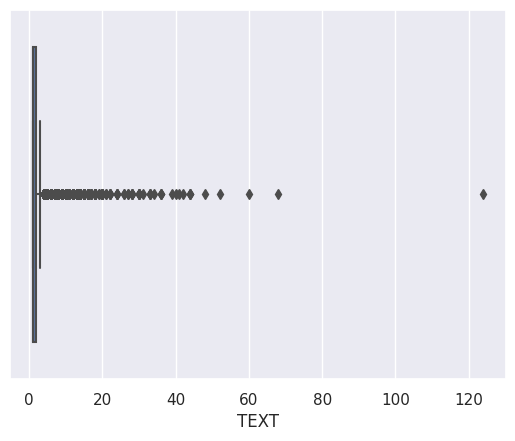

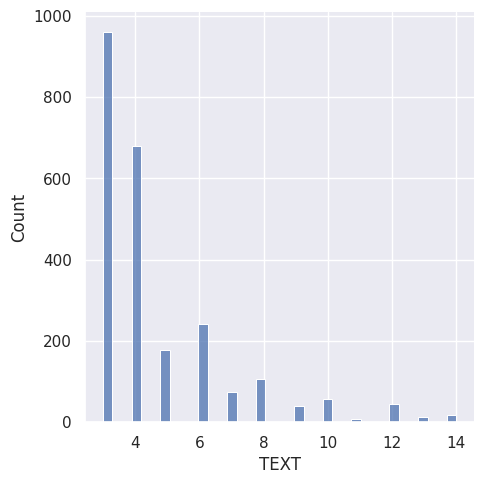

In [ ]:
sns.set()

gb_notes = deceased_TSICU.groupby(['CGID','SUBJECT_ID'])
num_notes = gb_notes['TEXT'].count()
print(num_notes)
print(f'number of notes: min={num_notes.min()}, max={num_notes.max()}, mean={num_notes.mean()},  median={num_notes.median()}')
sns.boxplot(x=num_notes)
sns.displot(num_notes[((num_notes>2) & (num_notes<15))])

Seperate deceased and living

In [ ]:
deceased_patients = balanced_data[balanced_data['EXPIRE_FLAG'] == 1]
deceased_patients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19216 entries, 0 to 48418
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ROW_ID             19216 non-null  int64  
 1   SUBJECT_ID         19216 non-null  int64  
 2   CGID               19216 non-null  int64  
 3   TEXT               19216 non-null  object 
 4   CATEGORY           19216 non-null  object 
 5   LABEL              17723 non-null  object 
 6   DESCRIPTION        10894 non-null  object 
 7   HADM_ID            19216 non-null  int64  
 8   ICUSTAY_ID         19216 non-null  int64  
 9   LOS                19216 non-null  float64
 10  GENDER             19216 non-null  object 
 11  EXPIRE_FLAG        19216 non-null  int64  
 12  ICD9_CODE          19216 non-null  object 
 13  SEQ_NUM            19216 non-null  int64  
 14  num_of_notes       19216 non-null  int64  
 15  num_of_conditions  19216 non-null  int64  
dtypes: float64(1), int64(9

In [ ]:
living_patients = balanced_data[balanced_data['EXPIRE_FLAG'] == 0]
living_patients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15067 entries, 77 to 48398
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ROW_ID             15067 non-null  int64  
 1   SUBJECT_ID         15067 non-null  int64  
 2   CGID               15067 non-null  int64  
 3   TEXT               15067 non-null  object 
 4   CATEGORY           15067 non-null  object 
 5   LABEL              14009 non-null  object 
 6   DESCRIPTION        8391 non-null   object 
 7   HADM_ID            15067 non-null  int64  
 8   ICUSTAY_ID         15067 non-null  int64  
 9   LOS                15067 non-null  float64
 10  GENDER             15067 non-null  object 
 11  EXPIRE_FLAG        15067 non-null  int64  
 12  ICD9_CODE          15067 non-null  object 
 13  SEQ_NUM            15067 non-null  int64  
 14  num_of_notes       15067 non-null  int64  
 15  num_of_conditions  15067 non-null  int64  
dtypes: float64(1), int64(

Tokenized words

In [ ]:
#text = df_notes_TSICU['TEXT'].str.cat(sep=' ')
#words = nltk.word_tokenize(text)  # very slow

Count words in notes

In [ ]:
#stopwords = nltk.corpus.stopwords.words('english')
#words = [word.lower() for word in words if word.lower() not in stopwords and re.match(r'\b\w+\b', word)]  # also slow but only kinda slow
#word_counts = Counter(words)
#most_common_words = word_counts.most_common(300)

In [ ]:
#print("Rank\tWord\t\t\tCount")
#for rank, word_count in enumerate(most_common_words, start=1):
  #word, count = word_count
  #print(f"{rank}\t{word.ljust(20)}\t{count}")

Emotional words

In [ ]:
#emotional_words = []
#for word_count in most_common_words:
  #word = word_count[0]
  #synsets = wn.synsets(word)
  #if synsets:
    #senti_synset = swn.senti_synset(synsets[0].name())
    #if senti_synset.pos_score() > 0.45 or senti_synset.neg_score() > 0.45:
      #emotional_words.append(word)

#emotional_words

In [ ]:
#from textblob import TextBlob
#emotional_words = []
#for word_count in most_common_words:
  #word = word_count[0]
  #tb = TextBlob(word)
  #sentiment = tb.sentiment.polarity
  #if abs(sentiment) > 0.35:
    #emotional_words.append(word)

#emotional_words